## Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import math

from pyteomics import fasta
from collections import defaultdict, namedtuple

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra
from src.postprocessing import review
from src import utils
from src.scoring import scoring
from src.objects import Spectrum

# Multiple datasets post analysis
Run multiple data sets and do some post processing to see how well we do overall

### Define the data

In [2]:
# define the list of datasets
# make it a list of tuples of (mzml, spectrum mill *sv, database, prefix dir)
Dataset = namedtuple(
    'Dataset', 
    ['spectra_dir', 'spectrumMill_results', 'full_database', 'highest_dir', 'filtered_fasta']
)


raw_prefix = '/Users/zacharymcgrath/Desktop/raw inputs/'


NOD2_data = Dataset(
    raw_prefix + 'NOD2_E3/mzml/', 
    raw_prefix + 'NOD2_E3/NOD2_E3_results.ssv', 
    raw_prefix + 'mouse_database.fasta', 
    raw_prefix + 'NOD2_E3/', 
    ''
)

BALB3_data = Dataset(
    raw_prefix + 'BALB3_E3/mzxml/', 
    raw_prefix + 'BALB3_E3/BALB3_E3.ssv', 
    raw_prefix + 'mouse_database.fasta',
    raw_prefix + 'BALB3_E3/', 
    ''
)

datasets = [NOD2_data, BALB3_data]


### Filter the data
We don't care about the spectra that don't get matches in spectrumMill because we need something to compare to. Additionally, create a filtered database for just the proteins that are found in the results

In [3]:
def db_filter(db_file: str, results_file: str, output_fasta: str) -> None:
    '''
    Create the subset of proteins needed for the database search
    
    Inputs:
        db_file:        (str)  the original fasta file
        results_file:   (str)  the results ssv file from spectrumMill
        output_fasta:   (str)  the fasta file to write to
    '''
    
    # load all protiens into a dictionary
    db = {}
    for entry in fasta.read(db_file):
        name = entry.description.split('|')[2]
        name = name[:name.index('OS=')-1]
        name = ' '.join(name.split(' ')[1:])
        db[name.lower()] = entry

    # load the results ssv into a dataframe 
    res_df = pd.read_csv(results_file, sep=';')
        
    print(f'Number of results: {len(res_df.index)}')

    # keep track of those we want
    filtered = []
    for idx, row in res_df.iterrows():
        key = row['entry_name'].lower()
        
        if key not in db:
            continue
            
        filtered.append(db[key])

    filtered = list(set(filtered))
    
    print(f'Number of proteins in database was reduced from {len(db)} to {len(filtered)}')
    
    fasta.write(filtered, output_fasta, file_mode='w')

In [4]:
updated_datasets = []

for dataset in datasets:
        
    # make a file name for the output for the filtered fasta file
    output_fasta = dataset.highest_dir + 'filtered_' + dataset.highest_dir.split('/')[-1].replace('/', '') + '_database.fasta'
        
    # check to see if we've created it before
    if not os.path.isfile(output_fasta):
        db_filter(dataset[2], dataset[1], output_fasta)
    
    updated_datasets.append(dataset._replace(filtered_fasta=output_fasta))

datasets = updated_datasets


In [5]:
d = pd.read_csv('/Users/zacharymcgrath/Desktop/raw inputs/BALB3_E3/BALB3_E3.ssv', sep=';')
d.loc[d['filename'].str.contains('BALB3_E3.1.1.2')]

,number,filename,parent_charge,score,deltaRank1Rank2Score,percent_scored_peak_intensity,num_unused_ions,totalIntensity,previous_aa,sequence,next_aa,sequenceMap,modifications,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,entry_name
9,10,BALB3_E3.14182.14222.2,2,14.28,11.12,89.1,6 / 25,263000.0,(G),DLQTLALEVARA,(D),(G)D L|Q|T|L|A/L/E V A R A(D),NaN,51.35,28.0,650.3670,HYBRID: mouse ins1C QLELGGSPGDLQTLALEVAR-ADEFP...
83,84,BALB3_E3.13152.13328.2,2,20.20,16.99,100.0,0 / 25,27300000.0,(E),DPQVAQLELGGGPGAGD,(L),(E)D P Q V\A\Q\L\E|L|G|G|G|P G|A G D(L),NaN,48.13,41.0,790.8827,Insulin-2
340,341,BALB3_E3.15132.15175.3,3,13.15,4.51,89.3,5 / 25,912000.0,(-),MLIKVKTLTGKEIEIDIEPT,(D),(-)M L|I K V K T L T G K E I E\I D\I|E|P/T(D),NaN,54.87,31.0,757.7679,NEDD8
350,351,BALB3_E3.19192.19232.3,3,11.52,2.71,80.9,8 / 25,483000.0,(K),DISLSEYKGKYVVFFFYPL,(D),(K)D I|S\L S E Y K G K Y V V F F F/Y|P L(D),NaN,69.32,10.0,772.4052,Peroxiredoxin-1
615,616,BALB3_E3.13192.13265.3,3,16.94,7.56,94.4,3 / 25,1020000.0,(-),MRYVASYLLAALGGNSSPSAK,(D),(-)M R Y V A S Y\L\L\A|A|L/G/G N S/S/P S A K(D),NaN,48.10,22.0,719.3777,60S acidic ribosomal protein P2
646,647,BALB3_E3.10112.10147.4,4,12.23,3.11,81.7,5 / 25,3370000.0,(Q),DKALMRLPYGPGKSRANQIPKVAWIP,(D),(Q)D/K\A L M R L P Y G P G K S R A N Q I\P K V...,NaN,37.60,17.0,727.4114,Secretogranin-2
694,695,BALB3_E3.12182.12328.2,2,14.06,8.62,83.5,4 / 25,4320000.0,(E),EQYTPQSLATL,(E),(E)E Q|Y\T|P Q S\L/A|T/L(E),NaN,44.87,25.0,625.8175,Secretogranin-2
879,880,BALB3_E3.10172.10212.3,3,13.02,6.95,81.6,10 / 25,754000.0,(I),DWAYYRANVAKPGLV,(D),(I)D W|A|Y/Y/R A N V A K/P G L V(D),NaN,37.77,15.0,574.9705,"ATP synthase subunit d, mitochondrial"


### Now run hyped search

In [6]:
min_pep = 3
max_pep = 30
tolerance = 20
precursor_tolerance = 10
peak_filter = 25
relative_abundance_filter = 0

for dataset in datasets:
        
    run_params = {
        'spectra_folder': dataset.spectra_dir,
        'database_file': dataset.filtered_fasta,
        'output_dir': dataset.highest_dir + 'output/',
        'min_peptide_len': min_pep,
        'max_peptide_len': max_pep,
        'tolerance': tolerance,
        'precursor_tolerance': precursor_tolerance,
        'peak_filter': peak_filter, 
        'relative_abundance_filter': relative_abundance_filter,
        'digest': '', 
        'missed_cleavages': 0,
        'verbose': True,
        'DEBUG': False,
        'cores': 16,
        'truth_set': '', 
        'n': 5
    }

    runner.run(run_params)
    
    print()

Loading database...
Done
Loading spectra...
File /Users/zacharymcgrath/Desktop/raw inputs/NOD2_E3/mzml/.DS_Store is not of supported types (mzML, mzXML)
Done
On batch 1/1
On protein 279/279 [100%]
Sorting the set of protein masses...
Done
Initializing other processors...
Done.
Creating an alignment for 1085/1086 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/raw inputs/NOD2_E3/output/...
Could not make an alignment for 1/1086 spectra (0%)

Loading database...
Done
Loading spectra...
File /Users/zacharymcgrath/Desktop/raw inputs/BALB3_E3/mzxml/.DS_Store is not of supported types (mzML, mzXML)
Done
On batch 1/1
On protein 228/228 [100%]
Sorting the set of protein masses...
Done
Initializing other processors...
Done.
Creating an alignment for 12165/12166 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/raw inputs/BALB3_E3/output/...
Could not make an alignment for 1094/12166 spectra (8%)



### Keep track of the output data location

In [7]:
output_data = [
    x[3] + 'output/summary.json' for x in datasets
]


## Total analysis (both hybrids and non hybrids)

### For each of the datasets, find out where the correct answer fell (no ties)

In [8]:
def dictify_table(df: pd.DataFrame, key: str, key_prepend: str = '') -> dict:
    '''
    Turn a pandas dataframe into a dictionary where the indices are the key specified
    '''
    ret_dict = {}
    
    prep = lambda k: key_prepend + str(k)
    
    for idx, row in df.iterrows():
        ret_dict[prep(row[key])] = dict(row)
    
    return ret_dict

In [9]:
results = defaultdict(lambda: 0)

individual_results = [defaultdict(lambda: 0) for _ in range(len(datasets))]

nf_key = 'not found'
na_key = 'no alignment'

# keep trock of the ranks keyed by id
id_keyed_results = {}

for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    nf = []
    na = []
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    print(f'Total number of SpectrumMill results: {len(specMill_results)}')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
    print(f'Total number of hyped search results: {len(hypedSearch_results)}')
        
    # index hypedSearch_results by the id value in key, value value['spectrum']
    
    # for BALB3, we need other_metadata[0]['parentFileName']    
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    else:
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        hybrid = False
        
        if 'hybrid' in value['entry_name'].lower():
            hybrid = True
        
        correct_sequence = value['sequence']
        
        
        # if hybrid, replace L and I with B
        if hybrid:
            correct_sequence = correct_sequence.replace('L', 'B').replace('I', 'B')
        
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            nf.append(key)
            results[nf_key] += 1
            individual_results[j][nf_key] += 1
            id_keyed_results[key] = nf_key
            continue 
            
        found = False
                    
        for i, alignment in enumerate(hypedSearch_results[key]['alignments']):
            
            comp_sequence = alignment['sequence']
            
            # if hybrid, replace L and I with B
            if hybrid:
                comp_sequence = comp_sequence.replace('L', 'B').replace('I', 'B')
            
            if comp_sequence == correct_sequence:
                results[str(i)] += 1
                individual_results[j][str(i)] += 1
                id_keyed_results[key] = i
                found = True
    
        if not found:
            na.append(key)
            results[na_key] += 1
            individual_results[j][na_key] += 1
            id_keyed_results[key] = na_key
    
    print(f'{len(nf)} ids not found in hypedSearch results that were found in spectrumMill')
    print(f'{len(na)} "correct" alignments from spectrumMill were not made in hyped search')
    print()
    

Total number of SpectrumMill results: 1086
Total number of hyped search results: 1086
0 ids not found in hypedSearch results that were found in spectrumMill
87 "correct" alignments from spectrumMill were not made in hyped search

Total number of SpectrumMill results: 971
Total number of hyped search results: 12166
0 ids not found in hypedSearch results that were found in spectrumMill
69 "correct" alignments from spectrumMill were not made in hyped search



### Plot it by all results (no ties)

In [10]:
sorted_int_keys = sorted([x for x in list(results.keys()) if x.isdigit()], key=lambda x: int(x))
non_int_keys = [x for x in list(results.keys()) if not x.isdigit()]

Text(0.5, 1.0, 'Number of results with a ranking for all datasets')

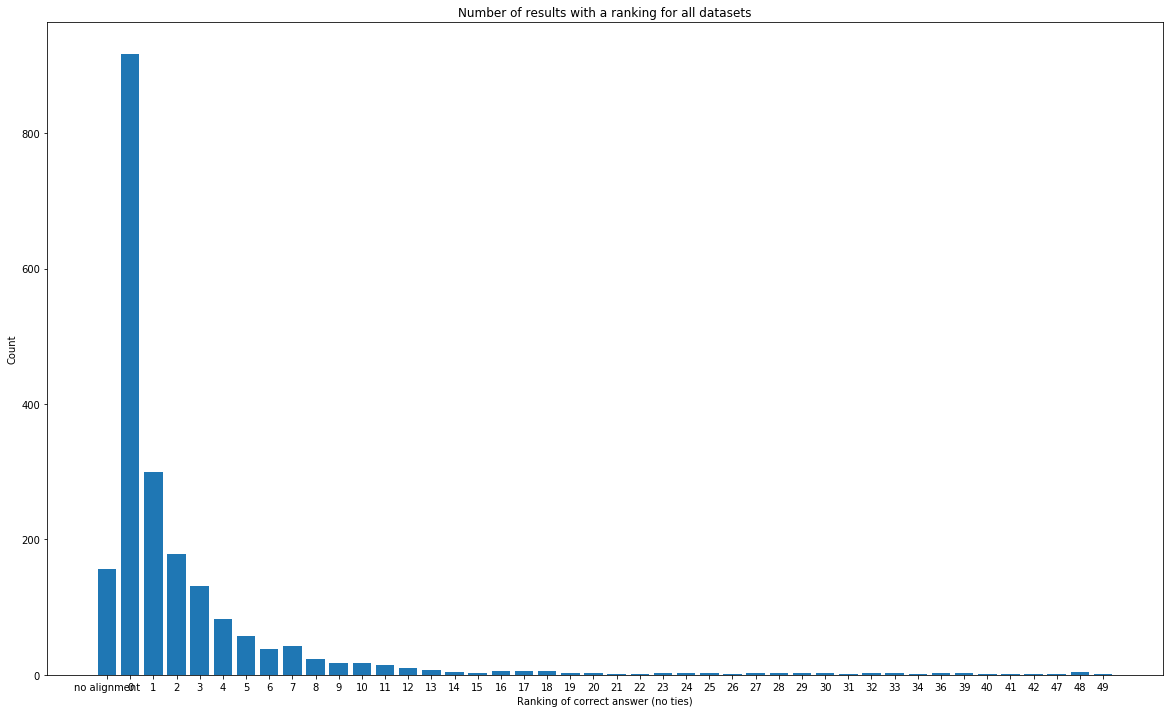

In [11]:
plt.figure(figsize=(20, 12))

plt.bar(non_int_keys + sorted_int_keys, [results[k] for k in non_int_keys] + [results[k] for k in sorted_int_keys])
plt.xlabel('Ranking of correct answer (no ties)')
plt.ylabel('Count')
plt.title('Number of results with a ranking for all datasets')

### Plot it by the dataset

1089 results for NOD2_E3
973 results for BALB3_E3


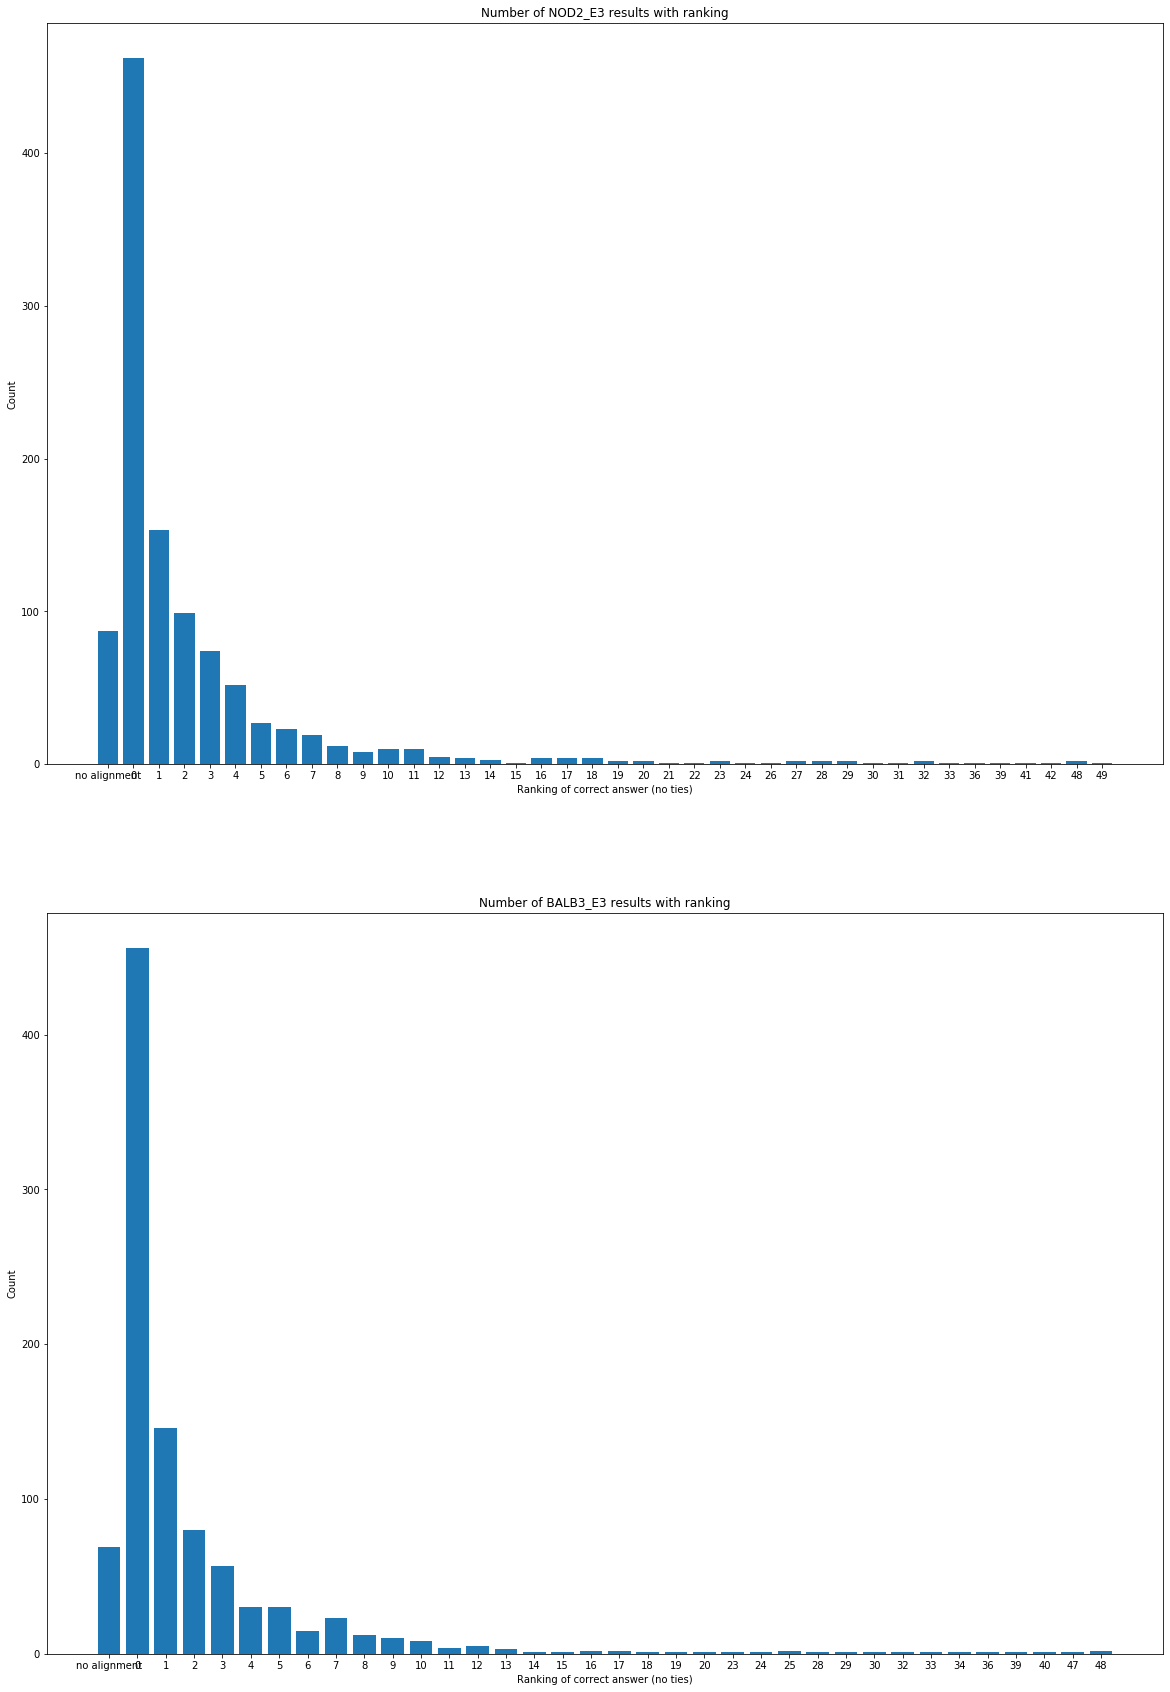

In [12]:
fig, axes = plt.subplots(len(individual_results), 1, figsize=(20, 15*len(individual_results)))

for i, ir in enumerate(individual_results):
        
    # first get the title
    dataset_name = datasets[i].highest_dir.split('/')[-2]
    title = f'Number of {dataset_name} results with ranking'
    
    # get the keys
    ir_sik = sorted([x for x in list(ir.keys()) if x.isdigit()], key=lambda x: int(x))
    ir_nik = [x for x in list(ir.keys()) if not x.isdigit()]
    
    axes[i].bar(ir_nik + ir_sik, [ir[k] for k in ir_nik] + [ir[k] for k in ir_sik])
    
    axes[i].set_title(title)
    axes[i].set_xlabel('Ranking of correct answer (no ties)')
    axes[i].set_ylabel('Count')
    
    all_res = sum([v for _, v in ir.items()])
    
    print(f'{all_res} results for {dataset_name}')

### For each of the datasets, find out where the correct answer fell (with ties)

In [13]:
results = defaultdict(lambda: 0)

individual_results = [defaultdict(lambda: 0) for _ in range(len(datasets))]

nf_key = 'not found'
na_key = 'no alignment'

for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    nf = []
    na = []
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
    
    # BALB dataset id found in another location
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
    else:
        # index hypedSearch_results by the id value in key, value value['spectrum']
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    
    
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        hybrid = False
        
        if 'hybrid' in value['entry_name'].lower():
            hybrid = True
        
        correct_sequence = value['sequence']
        
        # if hybrid, replace L and I with B
        if hybrid:
            correct_sequence = correct_sequence.replace('L', 'B').replace('I', 'B')
        
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            nf.append(key)
            results[nf_key] += 1
            individual_results[j][nf_key] += 1
            continue 
            
        found = False
        
        # since we can allow for ties, we need to bin by the scores
        scores = defaultdict(list)
                    
        for i, alignment in enumerate(hypedSearch_results[key]['alignments']):
            
            comp_sequence = alignment['sequence']
            
            # bin it 
            scores[alignment['total_score']].append(alignment)
            
            # if hybrid, replace L and I with B
            if hybrid:
                comp_sequence = comp_sequence.replace('L', 'B').replace('I', 'B')
            
            if comp_sequence == correct_sequence:
                # the correct result rank is the len(scores) - 1
                rank = str(len(scores) - 1)
                
                results[rank] += 1
                individual_results[j][rank] += 1
                found = True
                
        if not found:
            na.append(key)
            results[na_key] += 1
            individual_results[j][na_key] += 1
    

### Plot it by all results (with ties)

In [14]:
sorted_int_keys = sorted([x for x in list(results.keys()) if x.isdigit()], key=lambda x: int(x))
non_int_keys = [x for x in list(results.keys()) if not x.isdigit()]

Text(0.5, 1.0, 'Number of results with a ranking for all datasets')

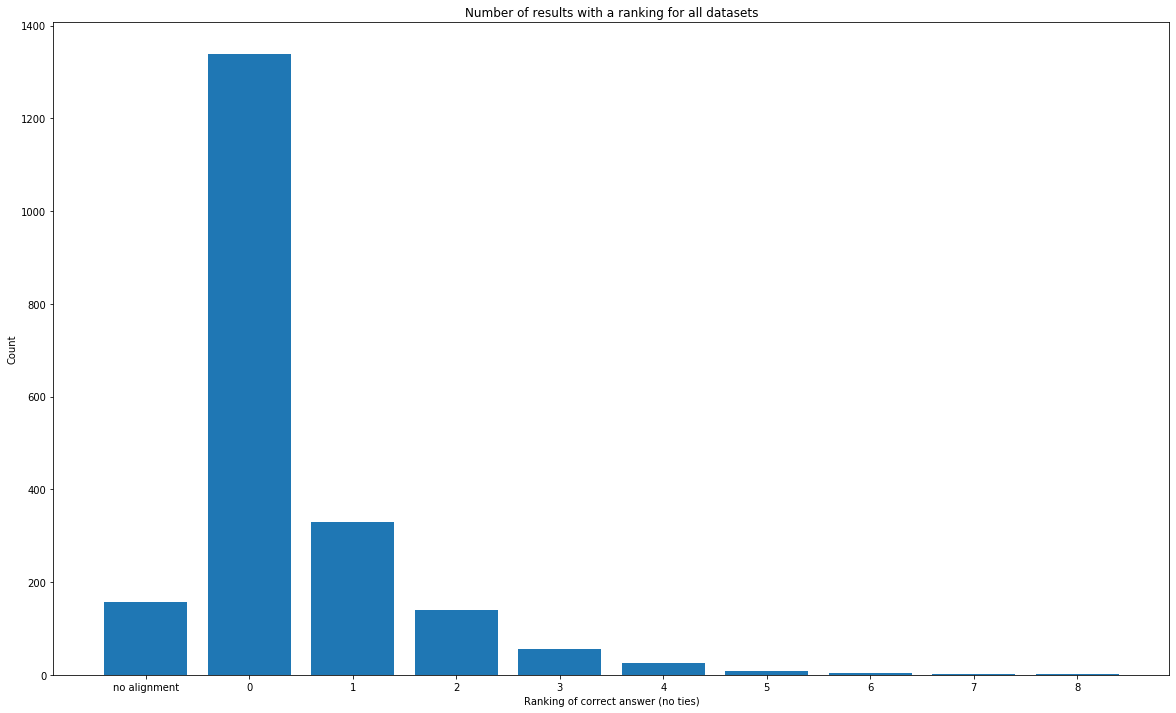

In [15]:
plt.figure(figsize=(20, 12))

plt.bar(non_int_keys + sorted_int_keys, [results[k] for k in non_int_keys] + [results[k] for k in sorted_int_keys])
plt.xlabel('Ranking of correct answer (no ties)')
plt.ylabel('Count')
plt.title('Number of results with a ranking for all datasets')

### Plot it by the dataset

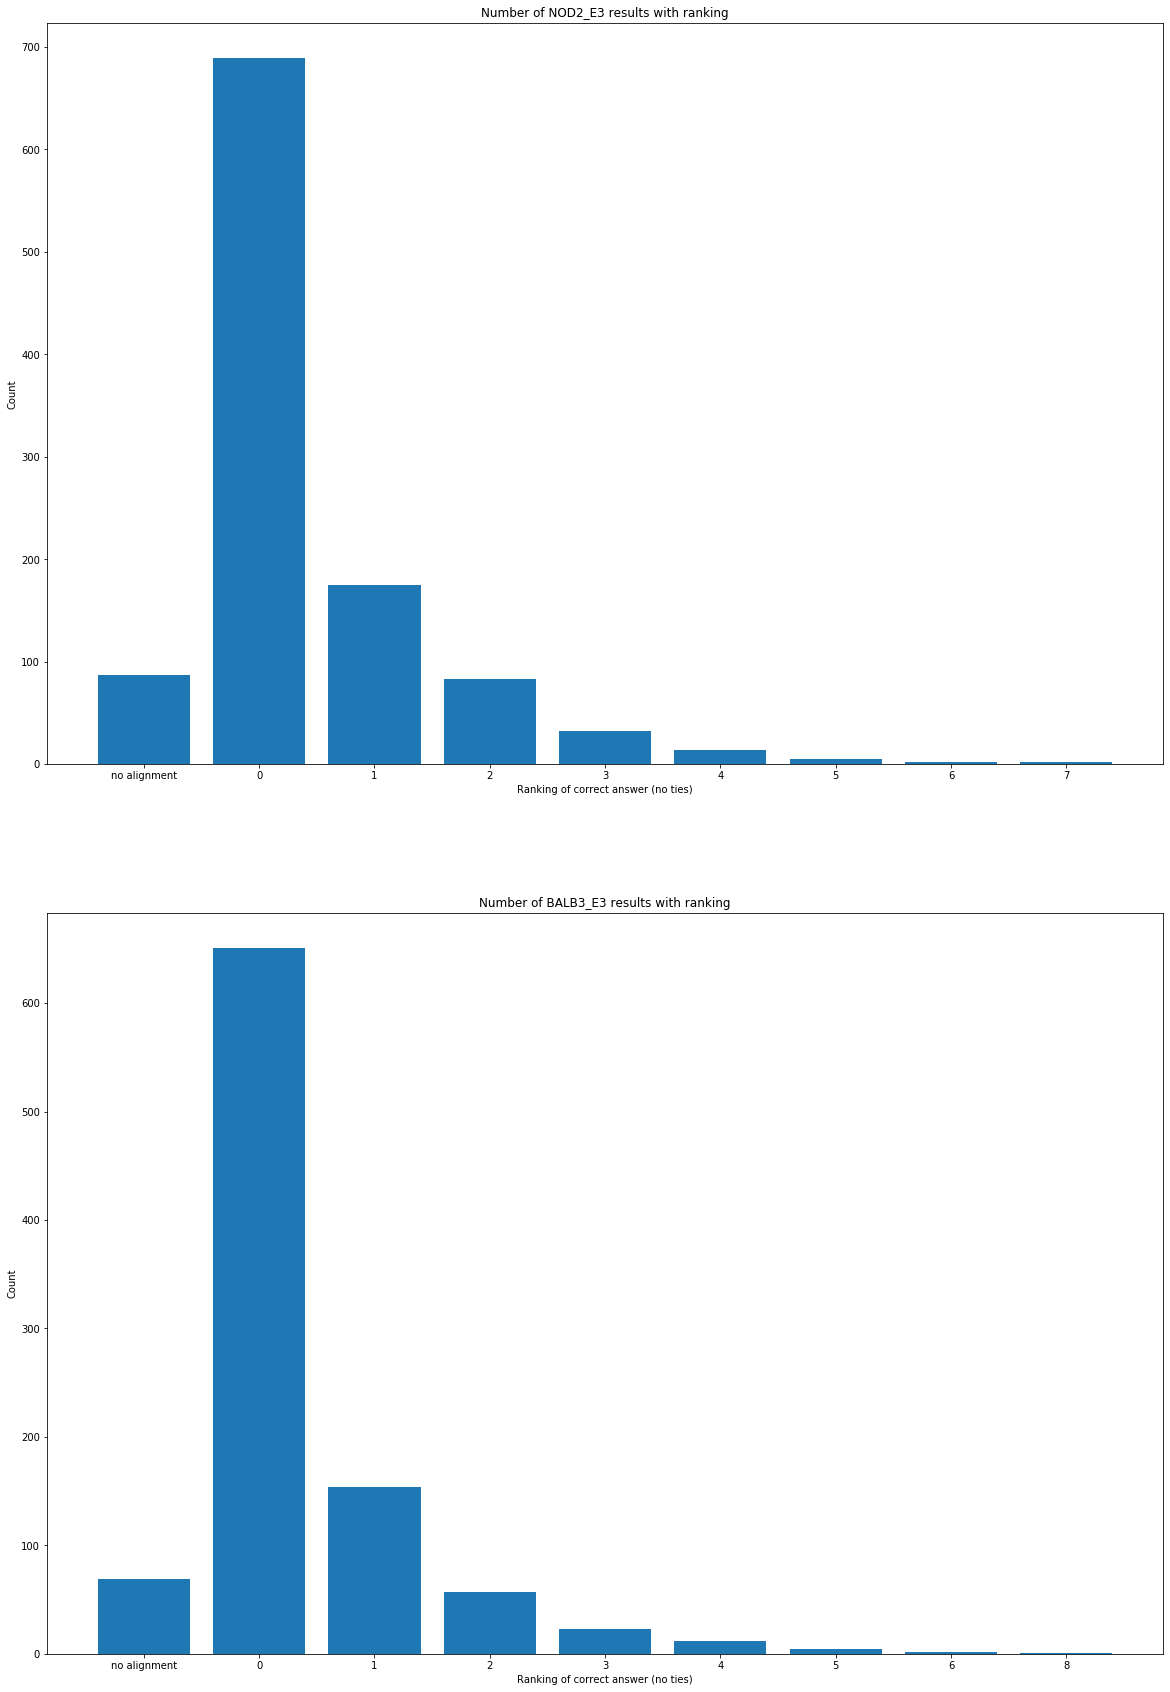

In [16]:
fig, axes = plt.subplots(len(individual_results), 1, figsize=(20, 15*len(individual_results)))

for i, ir in enumerate(individual_results):
    
    # first get the title
    title = datasets[i].highest_dir.split('/')[-2]
    title = f'Number of {title} results with ranking'
    
    # get the keys
    ir_sik = sorted([x for x in list(ir.keys()) if x.isdigit()], key=lambda x: int(x))
    ir_nik = [x for x in list(ir.keys()) if not x.isdigit()]
    
    axes[i].bar(ir_nik + ir_sik, [ir[k] for k in ir_nik] + [ir[k] for k in ir_sik])
    
    axes[i].set_title(title)
    axes[i].set_xlabel('Ranking of correct answer (no ties)')
    axes[i].set_ylabel('Count')

## Hybrid analysis

In [17]:
for j, (dataset, output) in enumerate(zip(datasets, output_data)):
    
    missed = []
    all_hybs = []
    
    print(f'Looking for hybrids in the dataset {dataset.highest_dir.split("/")[-2]}\n=====================================================')
    
    # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output, 'r'))
        
    # index hypedSearch_results by the id value in key, value value['spectrum']
    
    # for BALB3, we need other_metadata[0]['parentFileName']    
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    else:
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
    # now go through every result in specMill, find the corresponding one in hypedSearch, and add to results
    for key, value in specMill_results.items():
        
        # skip it if not a hybrid
        if not 'hybrid' in value['entry_name'].lower():
            continue
        
        # replace with B for easier comparison
        correct_sequence = value['sequence'].replace('L', 'B').replace('I', 'B')
        
        print(f'"Correct" hybrid sequence is {value["sequence"]}\n----------------------------------------')
    
        # look for it in the hypedSearch results
        if key not in hypedSearch_results:
            print(f'Alignment not made for {key}')
            
        found = False    
        
        # try to find a match for it 
        for i, alignment in enumerate(hypedSearch_results[key]['alignments']):
            
            print(f'{alignment["sequence"]} \t {alignment["total_score"]} \t {alignment["b_score"]} \t {alignment["y_score"]} \t {alignment["total_mass_error"]}')
            
            if alignment["sequence"].replace('L', 'B').replace('I', 'B') == correct_sequence:
                found = True
                break
                
        if not found:
            missed.append(key)
            
        all_hybs.append(key)
                
        print()
        
    print(f'Missed {len(missed)}/{len(all_hybs)} hybrids for dataset {dataset.highest_dir.split("/")[-2]}')
    
    print('\n')
        
        

Looking for hybrids in the dataset NOD2_E3
"Correct" hybrid sequence is DLQTLALLL
----------------------------------------
LATALTSPLL 	 7 	 4 	 3 	 0.007249227500011557
LATALTSPII 	 7 	 4 	 3 	 0.007249227500011557
LATALTSPIL 	 7 	 4 	 3 	 0.007249227500011557
LATALTSPLI 	 7 	 4 	 3 	 0.007249227500011557
DLQTLALIL 	 7.0 	 6 	 2 	 0.007388087148399336

"Correct" hybrid sequence is DPQVAQLELGGEVEDPQVAQLELGGGPGAG
----------------------------------------
DPQVAQLELGGEVEDPQVAQLELGGGPGAG 	 11.5 	 9 	 6 	 0.016867231641015223

"Correct" hybrid sequence is DLPVNSPMTKG
----------------------------------------
LDPVNSPMTKG 	 6.5 	 2 	 5 	 0.012423040742163494
DLPVNSPMTKG 	 6.5 	 2 	 5 	 0.012423040742163494

"Correct" hybrid sequence is DLQTLALWSRM
----------------------------------------
DLQTLALWSRM 	 12.5 	 5 	 8 	 0.02228520957024216

"Correct" hybrid sequence is DLQTLALNAAR
----------------------------------------
DLQTLALGAQR 	 12 	 4 	 8 	 0.012759324921319148
DLQTLALQQR 	 12 	 4 	 8 	 0.012

"Correct" hybrid sequence is DLQTLALLL
----------------------------------------
LTATIASPII 	 7 	 4 	 3 	 0.004857621132856593
SLSLVASPII 	 7 	 4 	 3 	 0.0050671187500768156
DLQTLALIL 	 5.5 	 4 	 2 	 0.007750080078182009

"Correct" hybrid sequence is DLQTLALEVARA
----------------------------------------
DLQTLALQLRE 	 13 	 5 	 8 	 0.0389634393751237
DLQTLALQLER 	 13.0 	 5 	 9 	 0.03910615300782183
DLQTLALQIER 	 13.0 	 5 	 9 	 0.03910615300782183
DLQTLALNGKNI 	 13 	 6 	 7 	 0.04409577121097641
DLQTLALQIRE 	 12.5 	 5 	 8 	 0.0389634393751237
DLQTLALAGLWV 	 12.5 	 5 	 8 	 0.0659110687498412
DLQTLALELQR 	 12 	 5 	 7 	 0.03662230144533396
DLQTLALEQIR 	 12 	 5 	 7 	 0.03662230144533396
DLQTLALQRLE 	 12 	 5 	 7 	 0.037086273124913305
DLQTLALQKGNV 	 12 	 5 	 7 	 0.03708627312502699
DLQTLALQERL 	 12 	 5 	 7 	 0.03708627312502699
DLQTLALQELR 	 12.0 	 5 	 8 	 0.03722898675783881
DLQTLAIQELR 	 12.0 	 5 	 8 	 0.03722898675783881
DLQTLALQEIR 	 12.0 	 5 	 8 	 0.03722898675783881
DLQTLALGAEIR 	 12.0 	 5

## Mass error distribution
Go through all the ids. If the id had a rank of 0, skip it. We want to plot the distribution of total mass error for the OUR top alignment as well as the spectrumMill one

In [18]:
all_hypedSearch_rank_tme = []
all_specMill_rank_tme = []

individual_hs_rank_tme = []
individual_sm_rank_tme = []

for i, dataset in enumerate(datasets):
    
    i_hs_rank_tme = []
    i_sm_rank_tme = []
    
     # first we need to index the spectrumMill results by id
    specMill_results = dictify_table(pd.read_csv(dataset[1], sep=';'), 'filename')
    
    # now we need to load the output data
    hypedSearch_results = json.load(open(output_data[i], 'r'))
    
    # for BALB3, we need other_metadata[0]['parentFileName']    
    if 'BALB3' in dataset[1]:
        hypedSearch_results = {value['spectrum']['other_metadata'][0]['parentFileName'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
    else:
        hypedSearch_results = {value['spectrum']['id'].replace('.pkl', ''): value for _, value in hypedSearch_results.items()}
        
        
    for _id, result in hypedSearch_results.items():
        
        skip_hs = not _id in id_keyed_results
        skip_sm = not _id in specMill_results
        
            
        # see if the id got a result of 0
        if not skip_hs and id_keyed_results[_id] == 0:
            continue
            
        # get the total mass error from hypedsearch. key the results by id, get the alignments
        # at index from id_keyed_results, and get total_mass_error
            
        # if no alignment, skip the hypedSearch part
        if not skip_hs:
            rank = id_keyed_results[_id]
            
            if not (rank == nf_key or rank == na_key):
                
                all_hypedSearch_rank_tme.append((rank, hypedSearch_results[_id]['alignments'][rank]['total_mass_error']))
                i_hs_rank_tme.append((rank, hypedSearch_results[_id]['alignments'][rank]['total_mass_error']))
        
        # we have the calculate the tme for spectrumMill results
        if not skip_sm:
            spec = Spectrum(**hypedSearch_results[_id]['spectrum'])
            all_specMill_rank_tme.append((rank, scoring.total_mass_error(spec, specMill_results[_id]['sequence'], 20)))
            i_sm_rank_tme.append((rank, scoring.total_mass_error(spec, specMill_results[_id]['sequence'], 20)))
        
    individual_hs_rank_tme.append(i_hs_rank_tme)
    individual_sm_rank_tme.append(i_sm_rank_tme)

## Plot distribution of mass errors for all datasets

Text(0.04, 0.5, 'Frequency')

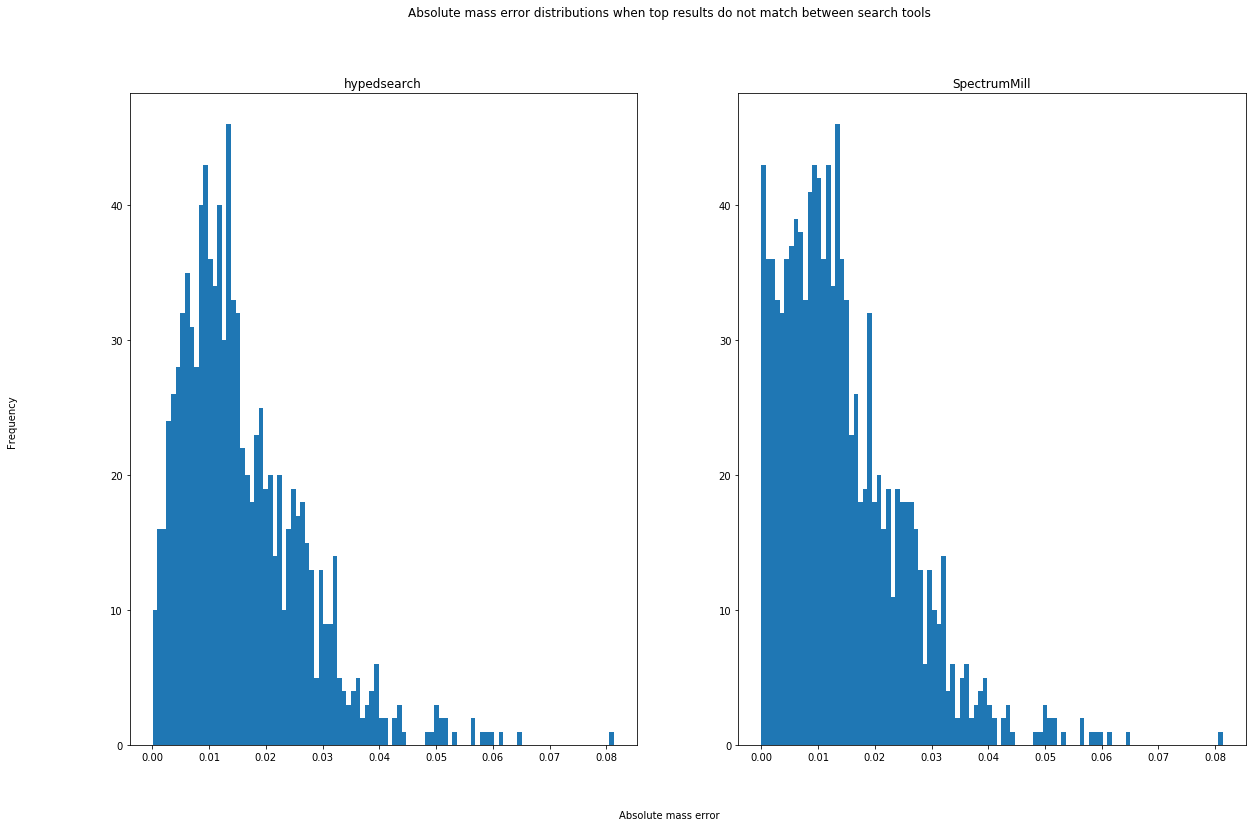

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

axes[0].hist([x[1] for x in all_hypedSearch_rank_tme], bins=100)
axes[0].set_title('hypedsearch')

axes[1].hist([x[1] for x in all_specMill_rank_tme], bins=100)
axes[1].set_title('SpectrumMill')

fig.suptitle('Absolute mass error distributions when top results do not match between search tools')
fig.text(0.5, 0.04, 'Absolute mass error', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

## Plot distribution of mass error per dataset

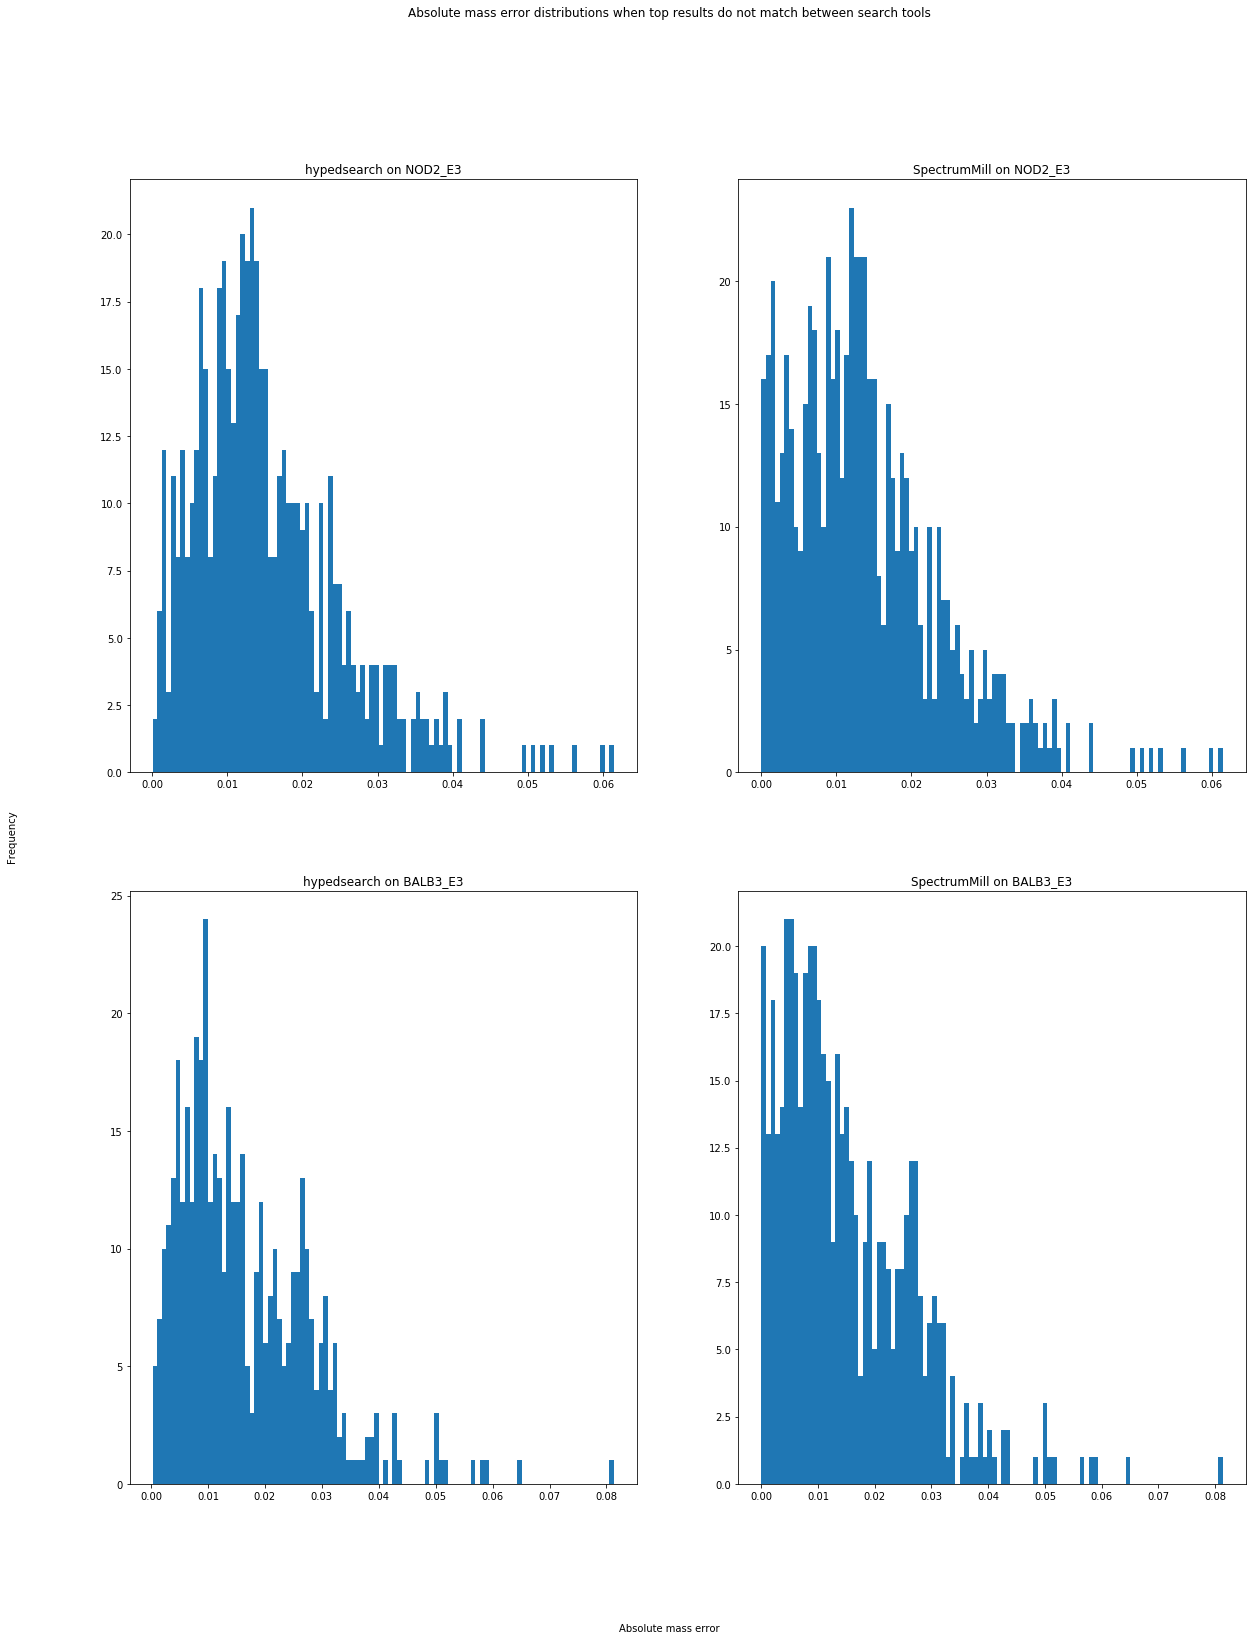

In [20]:
num_row = len(individual_hs_rank_tme)

fig, axes = plt.subplots(num_row, 2, figsize=(20, 12 * num_row))

fig.text(0.5, 0.04, 'Absolute mass error', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

fig.suptitle('Absolute mass error distributions when top results do not match between search tools')

for i, (hs_rank_tme, sm_rank_tme) in enumerate(zip(individual_hs_rank_tme, individual_sm_rank_tme)):

    dataset_name = datasets[i].highest_dir.split('/')[-2]
    
    axes[i][0].hist([x[1] for x in hs_rank_tme], bins=100)
    axes[i][0].set_title(f'hypedsearch on {dataset_name}')
    
    axes[i][1].hist([x[1] for x in sm_rank_tme], bins=100)
    axes[i][1].set_title(f'SpectrumMill on {dataset_name}')
    